In [1]:
# ======================================================================================
# 1. IMPORTS
# ======================================================================================

# --- Standard libraries ---
import os
import random

# --- Data libraries ---
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- PyTorch Core ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- Transforms and albumentations ---
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2


# ======================================================================================
# 2. Env. Codes
# ======================================================================================

DATASET_PATH = "/kaggle/input/a0-2025-medical-image-segmentation/Dataset" # <- BU SATIR DEĞİŞTİRİLDİ

TRAIN_IMAGE_DIR = os.path.join(DATASET_PATH, "Train/Image")
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, "Train/Mask")
TEST_DIR = os.path.join(DATASET_PATH, "Test/Image")

# --- Constants for the image size
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# --- Validation of the path
# print("Dataset print...")
# !ls -R "{DATASET_PATH}"

# Gpu availability check.
print("\nGPU check:")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if 'failed' in gpu_info or 'command not found' in gpu_info:
  print('-> There is no gpu...')
else:
  print(gpu_info)


GPU check:


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Thu Jun 26 06:54:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Total image-mask pairs found: 1087
Number of training pairs: 869
Number of validation pairs: 218

Example training pair (Mask, Image): ('/kaggle/input/a0-2025-medical-image-segmentation/Dataset/Train/Mask/0000963.png', '/kaggle/input/a0-2025-medical-image-segmentation/Dataset/Train/Image/0000963.jpg')

Displaying a sample pair from the training set...


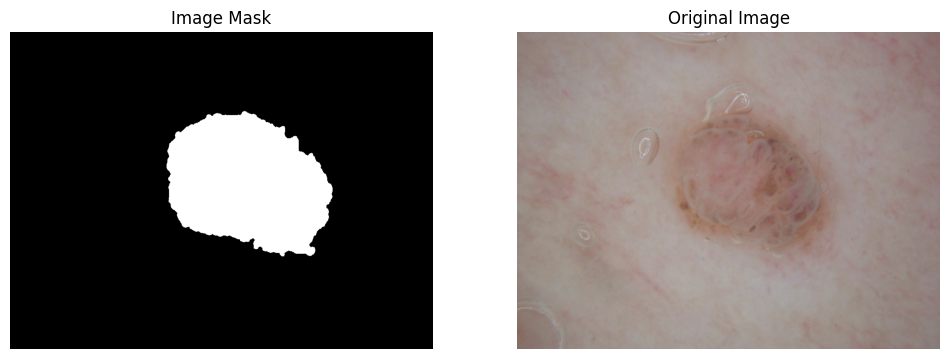

In [2]:
# ======================================================================================
# 3. DATA PREPARATION
# This cell finds all image-mask pairs, shuffles them, and splits them
# into training and validation sets.
# ======================================================================================

# --- 3.1. Find and Pair Images with Masks ---

# Get a list of all mask filenames from the mask directory.
# We assume that for every mask file, a corresponding image file exists.
mask_files = sorted([f for f in os.listdir(TRAIN_MASK_DIR) if f.lower().endswith('.png')])

# Create a list of tuples, where each tuple contains the full path
# to a mask and its corresponding image.
# We assume image files are .jpg and have the same name as the .png masks.
image_mask_pairs = [
    (os.path.join(TRAIN_MASK_DIR, name), os.path.join(TRAIN_IMAGE_DIR, name.replace(".png", ".jpg")))
    for name in mask_files
]

print(f"Total image-mask pairs found: {len(image_mask_pairs)}")


# --- 3.2. Shuffle and Split the Dataset (80/20) ---

# Set a random seed for reproducibility. This ensures the shuffle is the same every time.
random.seed(42)
random.shuffle(image_mask_pairs)

# Calculate the split index for an 80% training and 20% validation set.
split_idx = int(len(image_mask_pairs) * 0.8)
train_pairs = image_mask_pairs[:split_idx]
val_pairs = image_mask_pairs[split_idx:]


# --- 3.3. Verify the Split and Display a Sample ---

# Print the number of pairs in each set to verify the split.
print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of validation pairs: {len(val_pairs)}")
print(f"\nExample training pair (Mask, Image): {train_pairs[0]}")

# Visualize the first training sample to ensure data is loaded correctly.
print("\nDisplaying a sample pair from the training set...")
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the mask
mask_sample = Image.open(train_pairs[0][0])
axs[0].imshow(mask_sample, cmap="gray")
axs[0].set_title("Image Mask")
axs[0].axis("off")

# Display the original image
image_sample = Image.open(train_pairs[0][1])
axs[1].imshow(image_sample)
axs[1].set_title("Original Image")
axs[1].axis("off")

plt.show()

In [3]:
# ======================================================================================
# 4. DATA PIPELINE SETUP
# This cell defines the transformations, the custom Dataset class,
# and creates the DataLoader instances for training and validation.
# ======================================================================================

# --- 4.1. Define Image and Mask Transformations using Albumentations ---

BATCH_SIZE = 8
NUM_WORKERS = 2

# Define the augmentations for the training set.
# These random transformations help the model generalize better and prevent overfitting.
train_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=35, p=0.5),
    A.ColorJitter(p=0.2), # This is applied only to the image.
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(), # Converts image and mask to PyTorch Tensors.
])

# Define the transformations for the validation set.
# No random augmentations are applied to ensure consistent evaluation.
val_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])


# --- 4.2. Create the Custom Dataset Class ---

class SegmentationDataset(Dataset):
    """
    Custom PyTorch Dataset for loading image-mask pairs.
    It uses Albumentations for synchronized transformations on both
    the image and the mask.
    """
    def __init__(self, image_mask_pairs, transform=None):
        self.image_mask_pairs = image_mask_pairs
        self.transform = transform

    def __len__(self):
        # Returns the total number of samples in the dataset.
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        # Get the file paths for the image and mask at the given index.
        mask_path, image_path = self.image_mask_pairs[idx]

        # Load image and mask using OpenCV.
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB.
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Normalize mask to be binary (0.0 or 1.0) and of type float32.
        # This is a critical step to ensure the loss function works correctly.
        mask = (mask / 255.0 > 0.5).astype(np.float32)

        # Apply transformations if they are provided.
        if self.transform:
            # Albumentations applies the same geometric transforms to both image and mask.
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            # Add a channel dimension to the mask for PyTorch [C, H, W] format.
            mask = mask.unsqueeze(0)

        return image, mask


# --- 4.3. Instantiate Datasets and DataLoaders ---
# We use the previously defined variables: BATCH_SIZE, NUM_WORKERS,
# train_pairs, and val_pairs.

# Create the training dataset instance
train_dataset = SegmentationDataset(
    image_mask_pairs=train_pairs,
    transform=train_transforms
)
# Create the training data loader
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

# Create the validation dataset instance
val_dataset = SegmentationDataset(
    image_mask_pairs=val_pairs,
    transform=val_transforms
)
# Create the validation data loader
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=NUM_WORKERS
)


# --- 4.4. Verify a Sample Batch ---
# It's good practice to check the output of the DataLoader to ensure
# tensor shapes are correct before starting the training.
try:
    print("DataLoaders created successfully.")
    images, masks = next(iter(train_loader))
    print(f"Image batch shape from train_loader: {images.shape}")
    print(f"Mask batch shape from train_loader: {masks.shape}")
    # Expected shapes:
    # Images: [BATCH_SIZE, 3, IMAGE_HEIGHT, IMAGE_WIDTH]
    # Masks:  [BATCH_SIZE, 1, IMAGE_HEIGHT, IMAGE_WIDTH]
except Exception as e:
    print(f"An error occurred while verifying the DataLoader: {e}")

DataLoaders created successfully.
Image batch shape from train_loader: torch.Size([8, 3, 256, 256])
Mask batch shape from train_loader: torch.Size([8, 1, 256, 256])


In [4]:
# ======================================================================================
# 5. MODEL ARCHITECTURE
# This cell defines the building blocks and the main U-Net model architecture.
# ======================================================================================

# --- 5.1. U-Net Building Block: Double Convolution ---

class DoubleConv(nn.Module):
    """A block consisting of two sequential convolutional layers,
    each followed by BatchNorm and ReLU activation.
    (Convolution => [BatchNorm] => ReLU) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            # Second convolutional layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


# --- 5.2. The U-Net Model ---

class RollasUnet(nn.Module):
    """
    The U-Net architecture for image segmentation.
    It consists of an encoder (contracting path), a bottleneck,
    and a decoder (expansive path) with skip connections.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super(RollasUnet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        # --- Encoder (Contracting Path) ---
        # Each 'down' block consists of a DoubleConv followed by a MaxPool.
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2)

        # --- Bottleneck ---
        self.bottleneck = DoubleConv(512, 1024)

        # --- Decoder (Expansive Path) ---
        # Each 'up' step consists of an up-convolution, a skip connection concatenation,
        # and a DoubleConv block.
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512) # Input is 512 (from upconv) + 512 (from skip)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256) # Input is 256 + 256

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128) # Input is 128 + 128

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64) # Input is 64 + 64

        # --- Final Output Layer ---
        # This final 1x1 convolution maps the 64-channel feature map to the
        # desired number of output channels (1 for binary segmentation).
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # --- Encoder Path ---
        # Pass input through each encoder block and save the output
        # for the skip connections before the pooling operation.
        skip1 = self.inc(x)
        skip2 = self.down1(self.pool(skip1))
        skip3 = self.down2(self.pool(skip2))
        skip4 = self.down3(self.pool(skip3))

        # --- Bottleneck ---
        x = self.bottleneck(self.pool(skip4))

        # --- Decoder Path ---
        # At each step, upsample, concatenate with the corresponding
        # skip connection, and pass through the DoubleConv block.
        x = self.up1(x)
        x = torch.cat([x, skip4], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, skip3], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, skip2], dim=1)
        x = self.conv3(x)

        x = self.up4(x)
        x = torch.cat([x, skip1], dim=1)
        x = self.conv4(x)

        # --- Final Output ---
        # The output 'logits' are the raw scores from the model.
        # They will be passed to a loss function like BCEWithLogitsLoss.
        logits = self.outc(x)
        return logits


# --- 5.3. Verify Model Architecture ---
# A quick test to ensure the model is wired correctly and the
# output shape matches the input shape (except for channels).

# Use the device defined in the first cell
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the model and move it to the configured device
model = RollasUnet(in_channels=3, out_channels=1).to(device)

# Create a dummy input tensor with the expected shape
dummy_input = torch.randn(BATCH_SIZE, 3, IMAGE_HEIGHT, IMAGE_WIDTH).to(device)

# Get the model's prediction
preds = model(dummy_input)

# Print the shapes to verify
print("--- Model Sanity Check ---")
print(f"Input tensor shape:  {dummy_input.shape}")
print(f"Output tensor shape: {preds.shape}")
print(f"Model successfully created and tested.")
# The output shape should be [BATCH_SIZE, 1, IMAGE_HEIGHT, IMAGE_WIDTH]
LEARNING_RATE = 1e-4 # Learning rate
NUM_EPOCHS = 25    # Number of epochs in neural network.

--- Model Sanity Check ---
Input tensor shape:  torch.Size([8, 3, 256, 256])
Output tensor shape: torch.Size([8, 1, 256, 256])
Model successfully created and tested.


In [5]:
# ======================================================================================
# 6. TRAINING SETUP: Loss, Optimizer, and Helper Functions
# This cell defines the components required for training the model.
# ======================================================================================

# --- 6.1. Custom Loss Function and Evaluation Metric ---

class DiceLoss(nn.Module):
    """
    Implements Dice Loss, calculated as 1 - Dice Coefficient.
    Useful for directly optimizing the Dice score metric.
    """
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Apply sigmoid to model outputs to get probabilities
        inputs = torch.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice_coeff

def dice_coefficient(preds, targets, smooth=1e-6):
    """
    Calculates the Dice Coefficient metric for evaluation.
    Args:
        preds (torch.Tensor): The model's raw output logits.
        targets (torch.Tensor): The ground truth masks.
    Returns:
        float: The Dice Coefficient score.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

def combined_loss(pred, target):
    """
    A combined loss function that balances between BCE and Dice loss.
    This helps with both pixel-level accuracy and segmentation overlap.
    """
    bce = nn.BCEWithLogitsLoss()
    dice = DiceLoss()
    # You can experiment with the weights, e.g., 0.8 for BCE and 0.2 for Dice
    return 0.5 * bce(pred, target) + 0.5 * dice(pred, target)


# ======================================================================================
# 7. INITIALIZE MODEL, LOSS, AND OPTIMIZER
# Prepare the main components for the training process.
# ======================================================================================

# Use variables defined in the first refactored cell
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
NUM_EPOCHS = 25 # You can increase this if the model is still learning

# Instantiate the model (assuming UNET class is defined in a previous cell)
model = RollasUnet(in_channels=3, out_channels=1).to(DEVICE)

# Define the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Lists to store metrics for plotting later
train_losses = []
val_losses = []
val_dice_scores = []
best_val_dice = 0.0 # Variable to track the best score for model saving


# ======================================================================================
# 8. EXECUTE THE TRAINING LOOP
# ======================================================================================

print("--- Starting Training ---")

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Training]", leave=False)

    for data, targets in train_loop:
        data = data.to(device=DEVICE)
        targets = targets.float().to(device=DEVICE)

        # Forward pass
        predictions = model(data)
        loss = loss_fn(predictions, targets)
        total_train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    total_val_dice = 0.0
    total_val_loss = 0.0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=DEVICE)
            targets = targets.float().to(device=DEVICE)
            predictions = model(data)

            # Calculate validation loss (using the same combined loss)
            val_loss = loss_fn(predictions, targets)
            total_val_loss += val_loss.item()

            # Calculate validation Dice score
            dice_score = dice_coefficient(predictions, targets)
            total_val_dice += dice_score

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_dice = total_val_dice / len(val_loader)
    val_losses.append(avg_val_loss)
    val_dice_scores.append(avg_val_dice)

    # --- Save the best model based on validation Dice score ---
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print(f"--> New best model saved with Dice score: {avg_val_dice:.4f}")

    # --- Print Epoch Summary ---
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Dice: {avg_val_dice:.4f}")

print("\n--- Training Finished ---")
print(f"Best validation Dice score achieved: {best_val_dice:.4f}")

--- Starting Training ---


--> New best model saved with Dice score: 0.7401
Epoch [1/25] | Train Loss: 0.4362 | Val Loss: 0.3481 | Val Dice: 0.7401


--> New best model saved with Dice score: 0.7813
Epoch [2/25] | Train Loss: 0.3329 | Val Loss: 0.3346 | Val Dice: 0.7813


--> New best model saved with Dice score: 0.8446
Epoch [3/25] | Train Loss: 0.2852 | Val Loss: 0.2599 | Val Dice: 0.8446


--> New best model saved with Dice score: 0.8577
Epoch [4/25] | Train Loss: 0.2526 | Val Loss: 0.2086 | Val Dice: 0.8577


--> New best model saved with Dice score: 0.8603
Epoch [5/25] | Train Loss: 0.2459 | Val Loss: 0.2067 | Val Dice: 0.8603


--> New best model saved with Dice score: 0.8826
Epoch [6/25] | Train Loss: 0.2187 | Val Loss: 0.1883 | Val Dice: 0.8826


Epoch [7/25] | Train Loss: 0.2088 | Val Loss: 0.2037 | Val Dice: 0.8643


Epoch [8/25] | Train Loss: 0.2045 | Val Loss: 0.1798 | Val Dice: 0.8689


Epoch [9/25] | Train Loss: 0.1964 | Val Loss: 0.1718 | Val Dice: 0.8728


Epoch [10/25] | Train Loss: 0.1882 | Val Loss: 0.1787 | Val Dice: 0.8629


Epoch [11/25] | Train Loss: 0.1911 | Val Loss: 0.1673 | Val Dice: 0.8782


Epoch [12/25] | Train Loss: 0.1782 | Val Loss: 0.1619 | Val Dice: 0.8722


Epoch [13/25] | Train Loss: 0.1796 | Val Loss: 0.1620 | Val Dice: 0.8758


Epoch [14/25] | Train Loss: 0.1725 | Val Loss: 0.1695 | Val Dice: 0.8820


Epoch [15/25] | Train Loss: 0.1583 | Val Loss: 0.1803 | Val Dice: 0.8821


--> New best model saved with Dice score: 0.8988
Epoch [16/25] | Train Loss: 0.1653 | Val Loss: 0.1440 | Val Dice: 0.8988


Epoch [17/25] | Train Loss: 0.1603 | Val Loss: 0.1430 | Val Dice: 0.8978


Epoch [18/25] | Train Loss: 0.1533 | Val Loss: 0.1454 | Val Dice: 0.8840


Epoch [19/25] | Train Loss: 0.1590 | Val Loss: 0.1415 | Val Dice: 0.8924


Epoch [20/25] | Train Loss: 0.1519 | Val Loss: 0.1403 | Val Dice: 0.8939


Epoch [21/25] | Train Loss: 0.1468 | Val Loss: 0.1435 | Val Dice: 0.8894


Epoch [22/25] | Train Loss: 0.1405 | Val Loss: 0.1438 | Val Dice: 0.8912


Epoch [23/25] | Train Loss: 0.1440 | Val Loss: 0.1345 | Val Dice: 0.8941


Epoch [24/25] | Train Loss: 0.1470 | Val Loss: 0.1382 | Val Dice: 0.8900


Epoch [25/25] | Train Loss: 0.1436 | Val Loss: 0.1380 | Val Dice: 0.8942

--- Training Finished ---
Best validation Dice score achieved: 0.8988



--- Visualizing a few predictions... ---


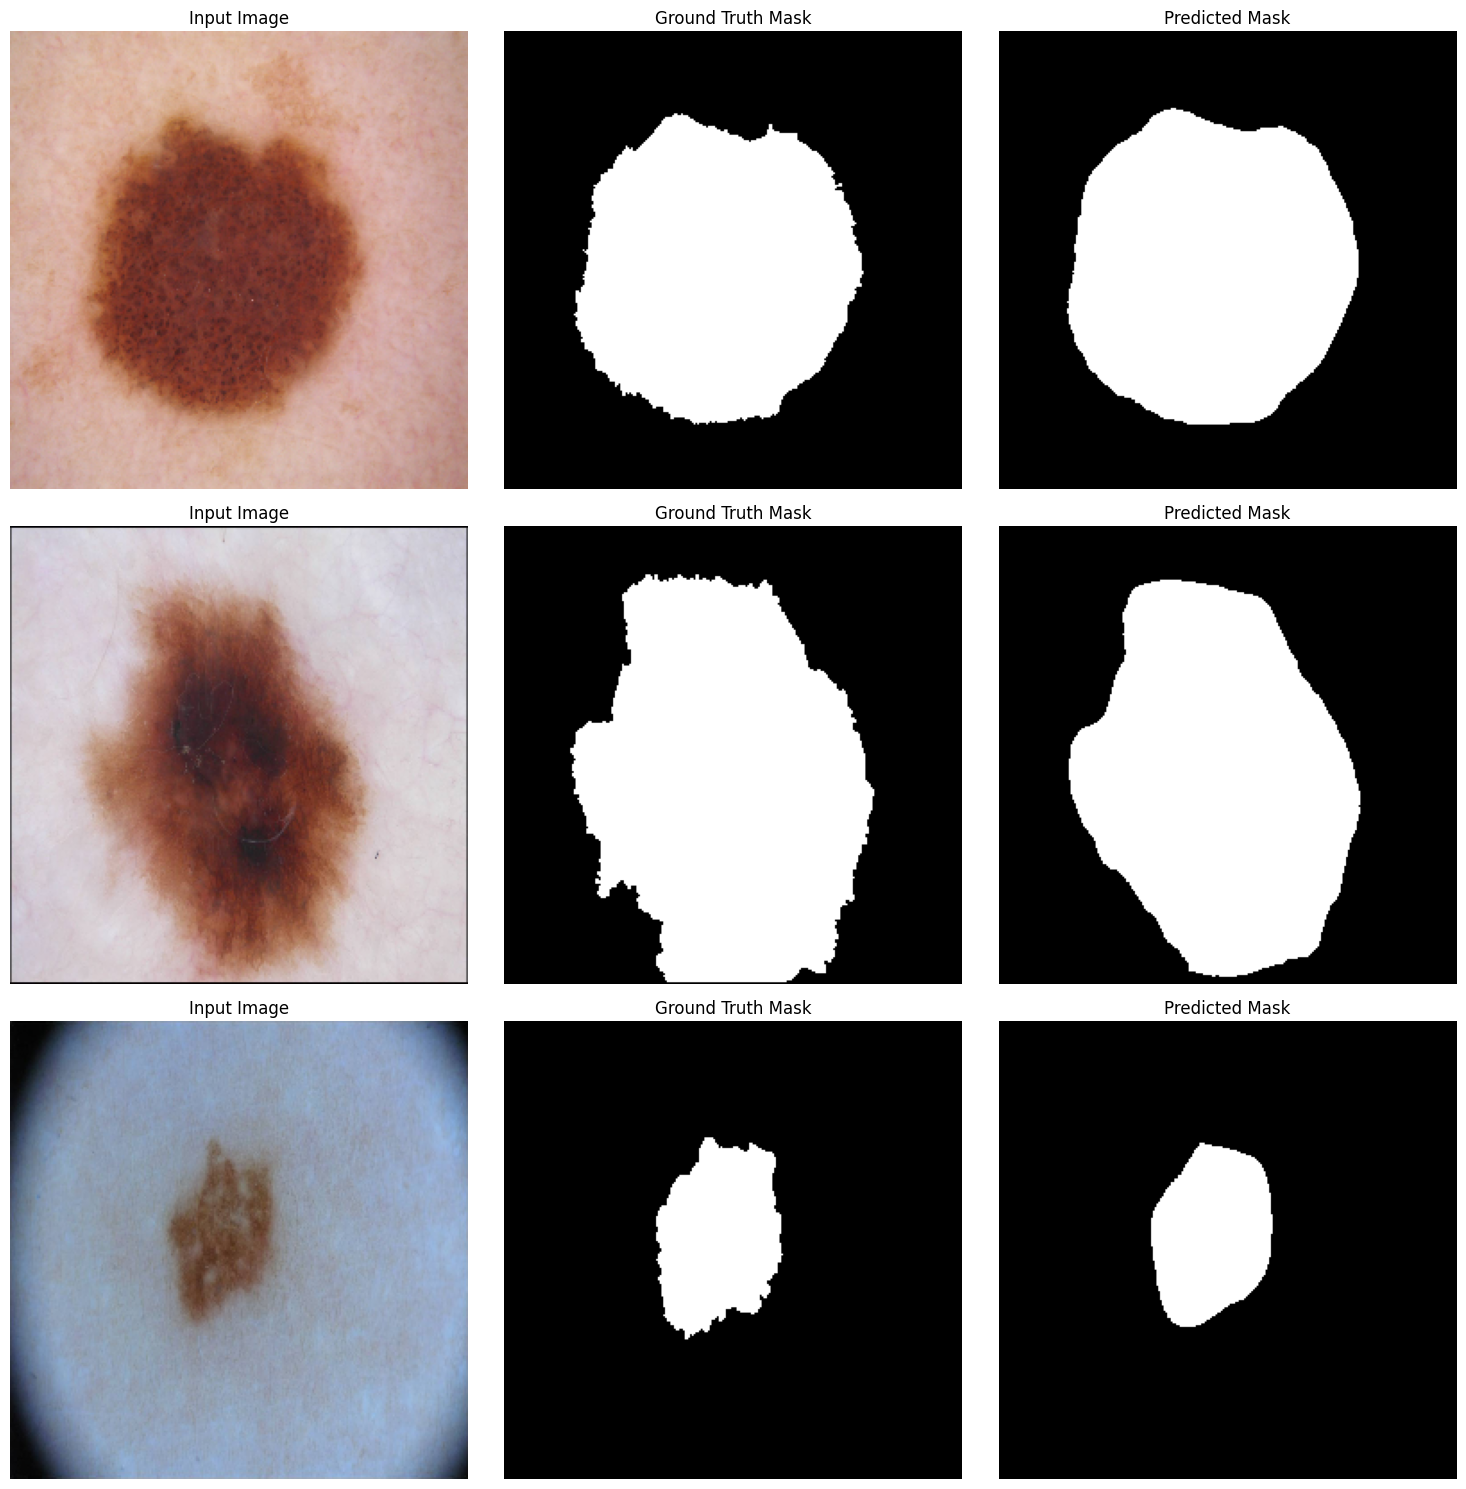

In [6]:
# ======================================================================================
# 9. VISUALIZE PREDICTIONS
# This cell defines a function to visualize the model's predictions on a few
# samples from a given data loader.
# ======================================================================================

def visualize_predictions(model, loader, device, num_images_to_show=3):
    """
    Visualizes model predictions against the ground truth masks.

    Args:
        model (torch.nn.Module): The trained model.
        loader (DataLoader): The DataLoader to get samples from (e.g., val_loader).
        device (str): The device to run the model on ("cuda" or "cpu").
        num_images_to_show (int): The number of sample images to display.
    """
    print("\n--- Visualizing a few predictions... ---")
    model.eval() # Set the model to evaluation mode

    # Get a single batch of data from the loader
    try:
        images, masks = next(iter(loader))
    except StopIteration:
        print("DataLoader is empty. Cannot visualize.")
        return

    images = images.to(device)

    with torch.no_grad():
        # Get model predictions
        preds = torch.sigmoid(model(images))
        # Apply threshold to get binary masks
        preds = (preds > 0.5).float()

    # Move tensors to CPU for plotting and convert to numpy arrays
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Determine how many images to show from the batch
    num_to_show = min(num_images_to_show, len(images))

    # Plot the images, ground truth masks, and predicted masks
    fig, axs = plt.subplots(num_to_show, 3, figsize=(15, num_to_show * 5))

    for i in range(num_to_show):
        # --- Denormalize the input image for better visualization ---
        # NOTE: These are the std and mean used in the transforms.
        # If you changed them, you must update these values too.
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])

        # Transpose image from [C, H, W] to [H, W, C] for matplotlib
        img_display = np.transpose(images[i], (1, 2, 0))

        # Apply the reverse transformation: (pixel * std) + mean
        img_display = std * img_display + mean

        # Clip values to [0, 1] range to handle potential floating point inaccuracies
        img_display = np.clip(img_display, 0, 1)

        # --- Plotting ---
        # If only one image is shown, axs is not a 2D array
        ax_row = axs[i] if num_to_show > 1 else axs

        # Original Image
        ax_row[0].imshow(img_display)
        ax_row[0].set_title("Input Image")
        ax_row[0].axis("off")

        # Ground Truth Mask
        ax_row[1].imshow(masks[i].squeeze(), cmap="gray")
        ax_row[1].set_title("Ground Truth Mask")
        ax_row[1].axis("off")

        # Predicted Mask
        ax_row[2].imshow(preds[i].squeeze(), cmap="gray")
        ax_row[2].set_title("Predicted Mask")
        ax_row[2].axis("off")

    plt.tight_layout()
    plt.show()


# --- Execute the visualization ---
# We call the function using the trained model and the validation loader.
# The model and val_loader should already be defined and available in the notebook.
visualize_predictions(model, val_loader, device=DEVICE)

In [7]:


class TestDataset(Dataset):
    """
    Custom PyTorch Dataset for loading test images.
    It returns the transformed image, its filename, and its original dimensions.
    """
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.image_names = sorted(os.listdir(test_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.test_dir, image_name)

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        original_height, original_width, _ = image.shape

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, image_name, (original_height, original_width)


# --- 10.2. Main Inference and Visualization Function ---

def generate_submission_and_visualize(model, device, test_dir, num_to_show=5):
    """
    Uses the trained model to generate predictions on the test set,
    creates a submission file, and visualizes some results.
    """
    # Define transformations for the test set (no augmentation)
    test_transforms = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
        ToTensorV2(),
    ])

    # Create the test dataset and dataloader
    test_dataset = TestDataset(test_dir, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    # Set model to evaluation mode
    model.eval()

    # Lists to store results
    
    images_to_display = []
    masks_to_display = []

    print("\n--- Generating predictions on the test set... ---")
    with torch.no_grad():
        for images, image_names, original_dims in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)

            # Get predictions (logits) and convert to binary masks
            preds = torch.sigmoid(model(images))
            preds = (preds > 0.5).cpu().numpy()

            for i in range(len(preds)):
                # --- Resize mask to original image dimensions ---
                pred_mask_256 = preds[i].squeeze().astype(np.uint8)
                original_h, original_w = original_dims[0][i].item(), original_dims[1][i].item()
                resized_mask = cv2.resize(pred_mask_256, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

                

                # Store some samples for visualization
                if len(images_to_display) < num_to_show:
                    original_image_path = os.path.join(test_dir, image_names[i])
                    images_to_display.append(original_image_path)
                    masks_to_display.append(resized_mask)

    

    # --- Visualize the stored samples ---
    print("\n--- Visualizing a few test predictions (in original size) ---")
    for i in range(len(images_to_display)):
        original_image = cv2.imread(images_to_display[i])
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        predicted_mask = masks_to_display[i]

        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        axs[0].imshow(original_image)
        axs[0].set_title(f"Original Test Image: {os.path.basename(images_to_display[i])}")
        axs[0].axis('off')

        axs[1].imshow(predicted_mask, cmap='gray')
        axs[1].set_title("Predicted Mask (Resized)")
        axs[1].axis('off')
        plt.show()


Loading best model weights from 'best_model.pth'...

--- Generating predictions on the test set... ---


Predicting: 100%|██████████| 24/24 [00:04<00:00,  5.09it/s]



--- Visualizing a few test predictions (in original size) ---


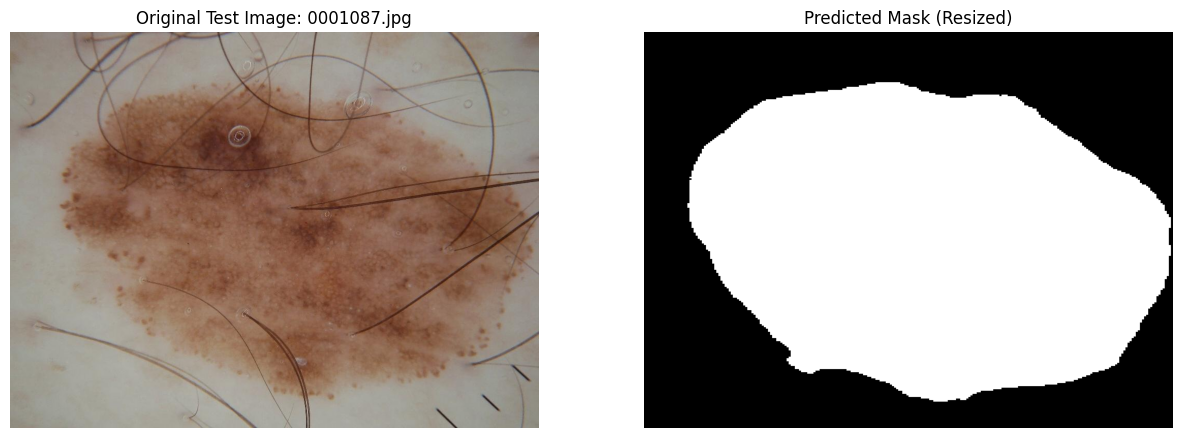

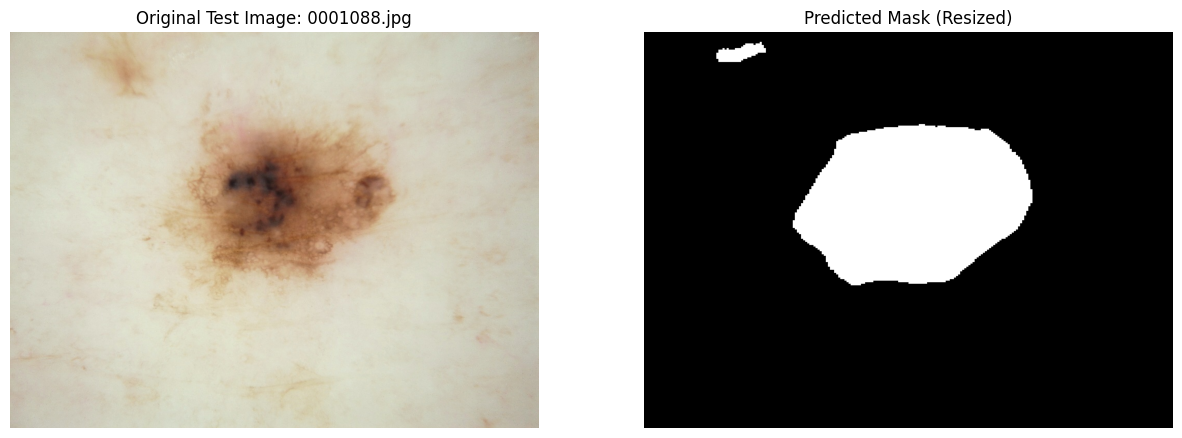

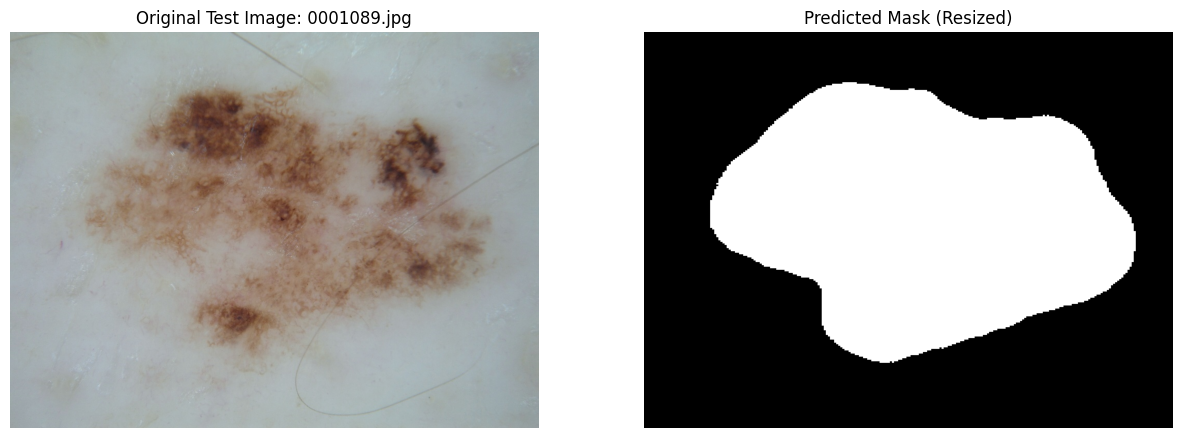

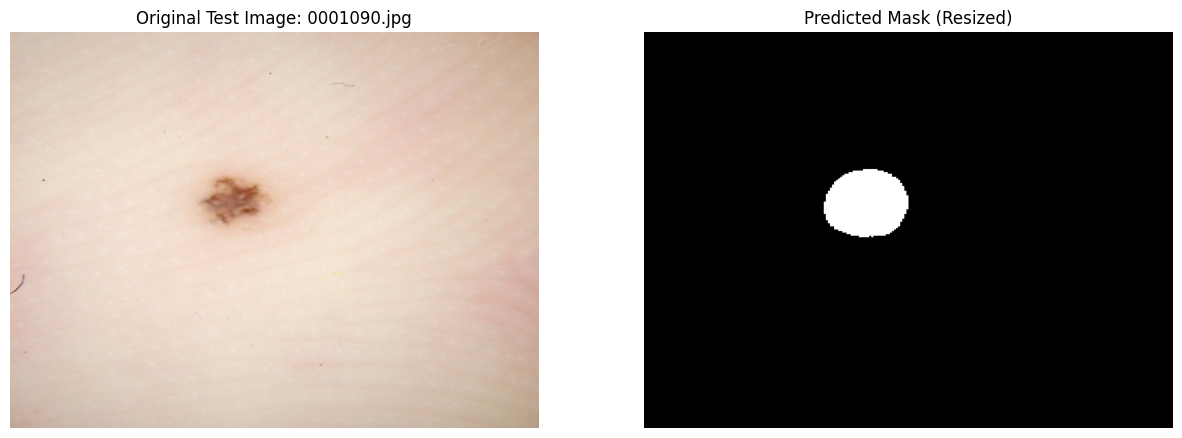

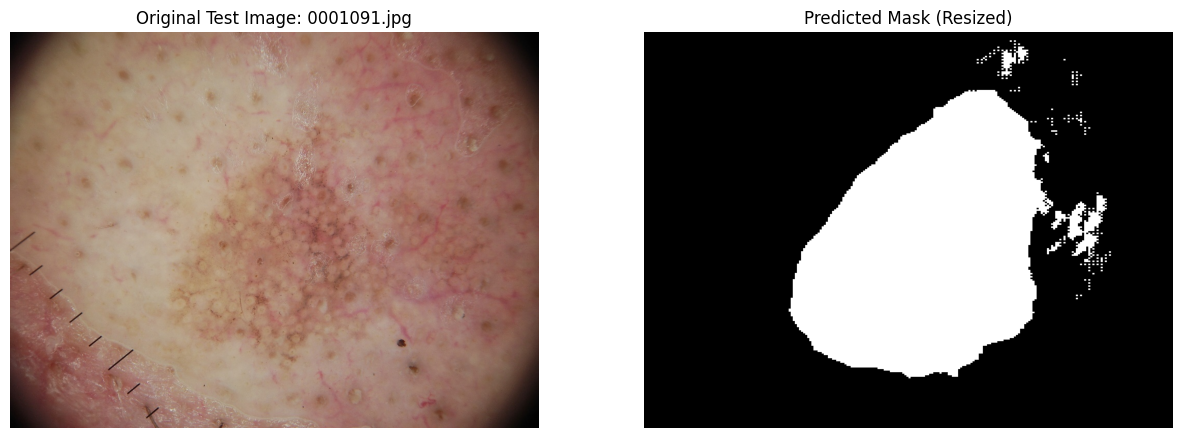

In [8]:
# Instantiate the model architecture
model = RollasUnet(in_channels=3, out_channels=1).to(DEVICE)

# Load the weights of the best performing model saved during training
print("Loading best model weights from 'best_model.pth'...")
try:
    model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
except FileNotFoundError:
    print("Error: 'best_model.pth' not found. Please ensure the model was trained and saved correctly.")
    # Handle error, maybe by stopping or using the current model in memory
else:
    # Run the submission and visualization pipeline
    generate_submission_and_visualize(model, DEVICE, TEST_DIR)